In [1]:
import bisect
import sys
from test_functions import test_functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
rec = 100000
sys.setrecursionlimit(rec)

In [14]:
def F(f, fdot, dots, x):
    new_index = bisect.bisect_right(dots[: -1], [x, float("inf"), 0, 0])
    #new index - 1, new index
    b, a, m = dots[new_index][0], dots[new_index - 1][0], dots[new_index - 1][3]
    y = y_ed(f, fdot, b, a, m)
    y_cup = y_ed_cup(f, fdot, b, a, m)
    if a <= x < y_cup:
        return f(a) + fdot(a) * (x - a) - (m / 2) * ((x - a) ** 2)
    elif y_cup <= x < y:
        temp_1 = fdot(b) - 2 * m * y + m * b
        temp_2 = f(b) - fdot(b) * b - 0.5 * m * (b ** 2) + m * (y ** 2)
        return 0.5 * m * (x ** 2) + temp_1 * x + temp_2
    elif y <= x <= b:
        return f(b) - fdot(b) * (b - x) - (m / 2) * ((b - x) ** 2)

In [15]:
def d_ed(f, fdot, b, a):
    temp_1 = (2 * (f(a) - f(b)) + (fdot(b) + fdot(a)) * (b - a)) ** 2
    temp_2 = ((fdot(b) - fdot(a)) ** 2) * ((b - a) ** 2)
    return (temp_1 + temp_2) ** (1 / 2)

In [16]:
def v_ed(f, fdot, b, a):
    d = d_ed(f, fdot, b, a)
    temp_1 = abs(2 * (f(a) - f(b)) + (fdot(b) + fdot(a)) * (b - a)) + d
    temp_2 = (b - a) ** (2)
    return temp_1 / temp_2

In [17]:
def y_ed(f, fdot, b, a, m):
    temp_1 = (b - a) / 4
    temp_2 = (fdot(b) - fdot(a)) / (4 * m)
    temp_3 = f(a) - f(b) + fdot(b) * b - fdot(a) * a + (0.5 * m * ((b ** 2) - (a ** 2)))
    temp_4 = m * (b - a) + fdot(b) - fdot(a)
    return temp_1 + temp_2 + (temp_3/temp_4)

In [18]:
def y_ed_cup(f, fdot, b, a, m):
    temp_1 = (b - a) / 4
    temp_2 = (fdot(b) - fdot(a)) / (4 * m)
    temp_3 = f(a) - f(b) + fdot(b) * b - fdot(a) * a + (0.5 * m * ((b ** 2) - (a ** 2)))
    temp_4 = m * (b - a) + fdot(b) - fdot(a)
    return -temp_1 - temp_2 + (temp_3/temp_4)

In [19]:
def pi_dot(fdot, y, m, b, a):
    return fdot(b) - m * (y - b)

In [20]:
def pi_dot_cup(fdot, y_cup, m, b, a):
    return fdot(a) - m * (y_cup - a)

In [21]:
def charred(f, fdot, y, m, b, a, case):
    if case == 0:
        c = f(b) - fdot(b) * b - 0.5 * m * (b ** 2) + m * (y ** 2)
        x_cup = 2 * y - fdot(b) * (m ** (-1)) - b
        psi = c - 0.5 * m * (x_cup ** 2)
        char = min(f(a), f(b), psi)
        return char, 1
    elif case == 1:
        char = min(f(a), f(b))
        if f(a) < f(b):
            return char, 0
        else:
            return char, 2

In [22]:
def dlg(f, dots, fdot, counter):
    _, min_index, char_class = min([(y, i, cc) for i, (_, y, _, _ ,cc) in enumerate(dots)])

    if abs(dots[min_index + 1][0] - dots[min_index][0]) < epsilon_stop:
        func_values = [f(x) for (x, _, _, _, _) in dots]
        return min(func_values), counter

    counter += 1



    if char_class == 0:
        new_dot = y_ed_cup(f, fdot, dots[min_index + 1][0], dots[min_index][0], dots[min_index][3])
    elif char_class == 1:
        y = y_ed(f, fdot, dots[min_index + 1][0], dots[min_index][0], dots[min_index][3])
        new_dot = (2 * y) - (fdot(dots[min_index + 1][0]) * (dots[min_index][3] ** (-1))) - dots[min_index + 1][0]
    else:
        new_dot = y_ed(f, fdot, dots[min_index + 1][0], dots[min_index][0], dots[min_index][3])

    new_index = bisect.bisect_left(dots, [new_dot, float("inf"), -float("inf"), None, None])
    bisect.insort_left(dots, [new_dot, float("inf"), -float("inf"), None, None])

    v_1 = v_ed(f, fdot, dots[new_index][0], dots[new_index - 1][0])
    v_2 = v_ed(f, fdot, dots[new_index + 1][0], dots[new_index][0])

    dots[new_index - 1][2], dots[new_index][2] = v_1, v_2

    v, _ = max([(v, -index) for index, (_, _, v, _, _) in enumerate(dots)])

    x_max = max([dots[index + 1][0] - dots[index][0] for index, _ in enumerate(dots[:-1])])

    for index, dot in enumerate(dots[:-1]):
        gamma = (v / x_max) * (dots[index + 1][0] - dots[index][0])
        if 0 < index < len(dots) - 2:
            lamb = max(dots[index][2], dots[index + 1][2], dots[index - 1][2])
        elif index == 0:
            lamb = max(dots[index][2], dots[index + 1][2])
        elif index == len(dots) - 2:
            lamb = max(dots[index][2], dots[index - 1][2])

        dot[3] = tau * max(lamb, gamma, epsilon)


    for i in range(len(dots) - 1):
        y_cup = y_ed_cup(f, fdot, dots[i + 1][0], dots[i][0], dots[i][3])
        y = y_ed(f, fdot, dots[i + 1][0], dots[i][0], dots[i][3])
        pi_1 = pi_dot_cup(fdot, y_cup, dots[i][3], dots[i + 1][0], dots[i][0])
        pi_2 = pi_dot(fdot, y, dots[i][3], dots[i + 1][0], dots[i][0])
        if pi_1 * pi_2 >= 0:
            char, char_class = charred(f, fdot, y, dots[i][3], dots[i + 1][0], dots[i][0], 1)
            dots[i][1], dots[i][4] = char, char_class
        else:
            char, char_class = charred(f, fdot, y, dots[i][3], dots[i + 1][0], dots[i][0], 0)
            dots[i][1], dots[i][4] = char, char_class
    return dgg(f, dots, fdot, counter)

In [23]:
epsilon = 10 ** (-9)
tau = 1.11

In [24]:
xarrays, yarrays, ogarrays = [], [], []
for index, func in enumerate(test_functions):
    x_arr = np.linspace(func.interval[0], func.interval[1], 1200)
    ys = []
    og = []
    f, fdot, a, b, L, counter = func.f, func.fdot, func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    v = v_ed(f, fdot, b, a)
    m = tau * max(v, epsilon)
    y = y_ed(f, fdot, b, a, m)
    y_cup = y_ed_cup(f, fdot, b, a, m)
    pi = pi_dot(fdot, y, m, b, a)
    pi_cup = pi_dot_cup(fdot, y_cup, m, b, a)
    if (pi * pi_cup) >= 0:
        char, char_class = charred(f, fdot, y, m, b, a, 1)
    else:
        char, char_class = charred(f, fdot, y, m, b, a, 0)
    dots  = [[a, char, v, m, char_class], [b, float("inf"), -float("inf"), None, None]]
    minval, count = dlg(f, dots, fdot, counter)
    print(index + 1, minval, count)
    for i in x_arr:
        ys.append(f(i))
        og.append(F(f, fdot, dots, i))
    xarrays.append(x_arr)
    yarrays.append(ys)
    ogarrays.append(og)

1 -29763.23332948902 10
2 -1.8995993473739343 10
3 -12.031249315915286 51
4 -3.850450708798872 11
5 -1.4890723024342083 13
6 -0.8242393279633432 20
7 -1.6013075422451166 9
8 -14.5080001933254 48
9 -1.9059610889224154 9
10 -7.916727369765442 9
11 -1.4999999987280934 18
12 -0.9999999999971236 17
13 -1.587401051560307 23
14 -0.7886853840859697 13
15 -0.035533905599006925 13
16 7.515924161227918 22
17 7.000001238966888 28
18 1.1407609369969522e-09 7
19 -7.815674541977504 10
20 -0.0634905289214492 21


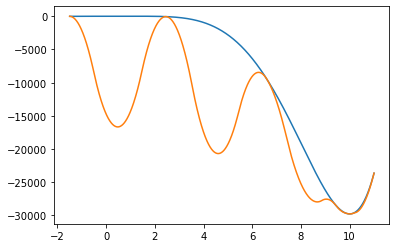

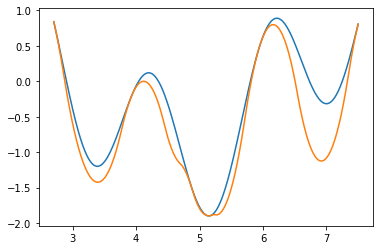

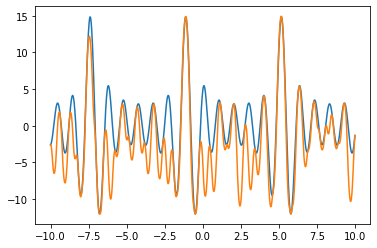

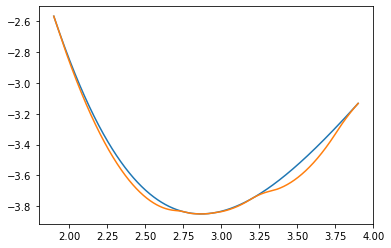

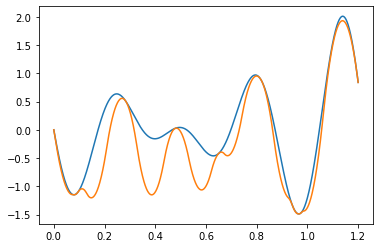

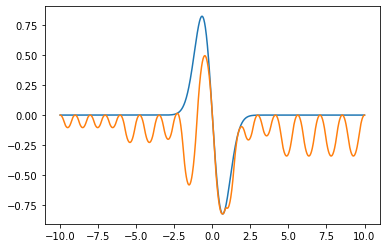

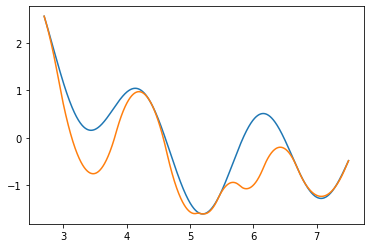

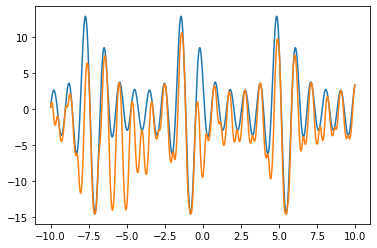

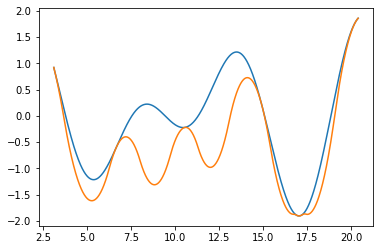

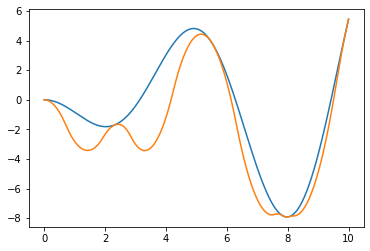

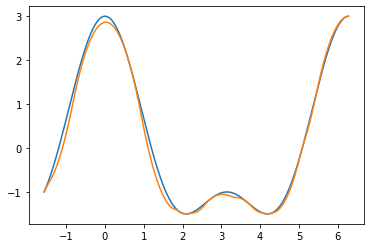

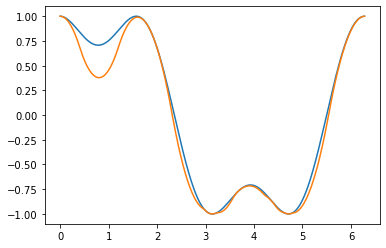

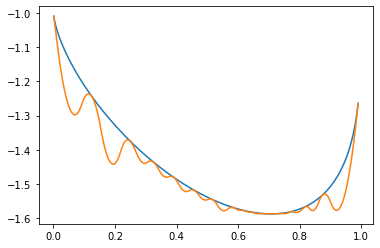

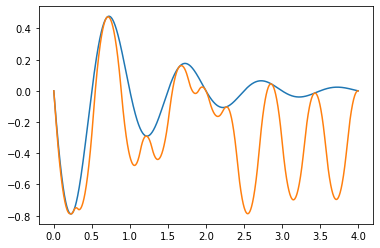

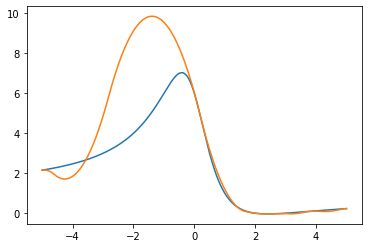

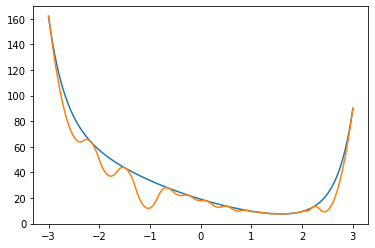

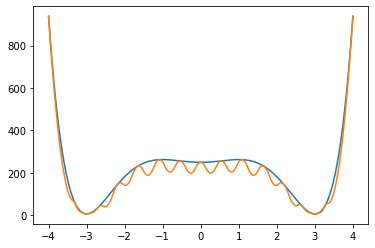

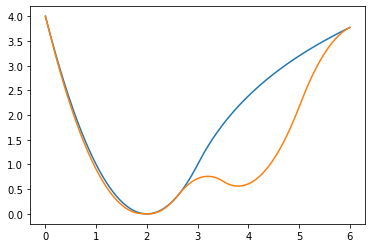

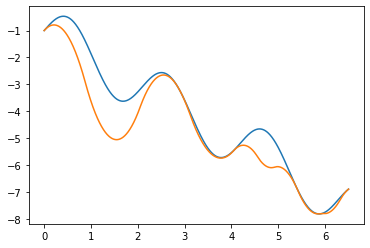

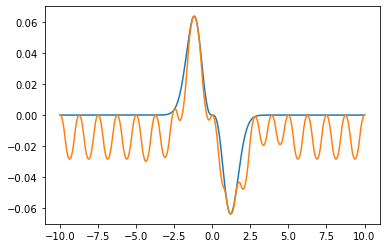

In [25]:
for index in range(20):
    plt.plot(xarrays[index], yarrays[index])
    plt.plot(xarrays[index], ogarrays[index])
    plt.show()